In [4]:
import pandas as pd
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from scipy.stats import spearmanr

from helper_functions import bins, tem

from Bio import SeqIO

In [5]:
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Plotting the data


In [6]:
## 
file = "../data/all_tms_noredun_780.fasta"
df_tm = {}
df_data = {"id": [], "Data set": [], "Melting Temperature": [] }
for rec in SeqIO.parse(file, "fasta"):
    df_tm[rec.id] = rec.description.split()[-1]
    df_data["id"].append(rec.id)
    df_data["Data set"].append(rec.description.split()[1])
    df_data["Melting Temperature"].append(float(rec.description.split()[-1]))

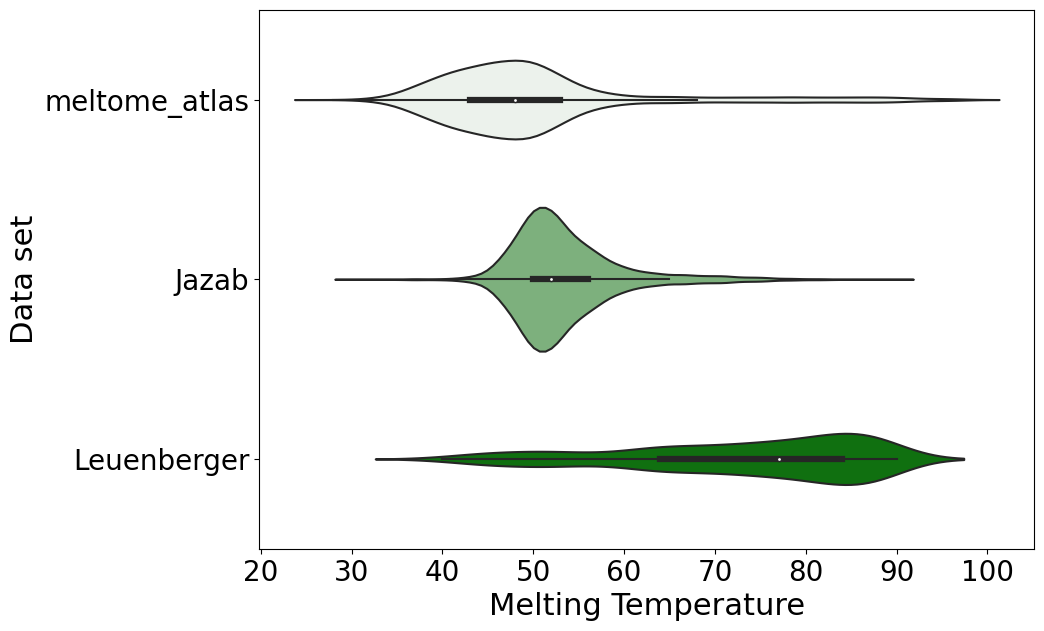

In [7]:
plt.figure(figsize=[10,7])
df_data = pd.DataFrame(df_data)
sns.violinplot(data=df_data, x= "Melting Temperature", y="Data set", palette="light:g", orient='h')
plt.show()

/tmp/ipykernel_12965/641916824.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_data, x= "Melting Temperature", palette="light:g", bins = 71)


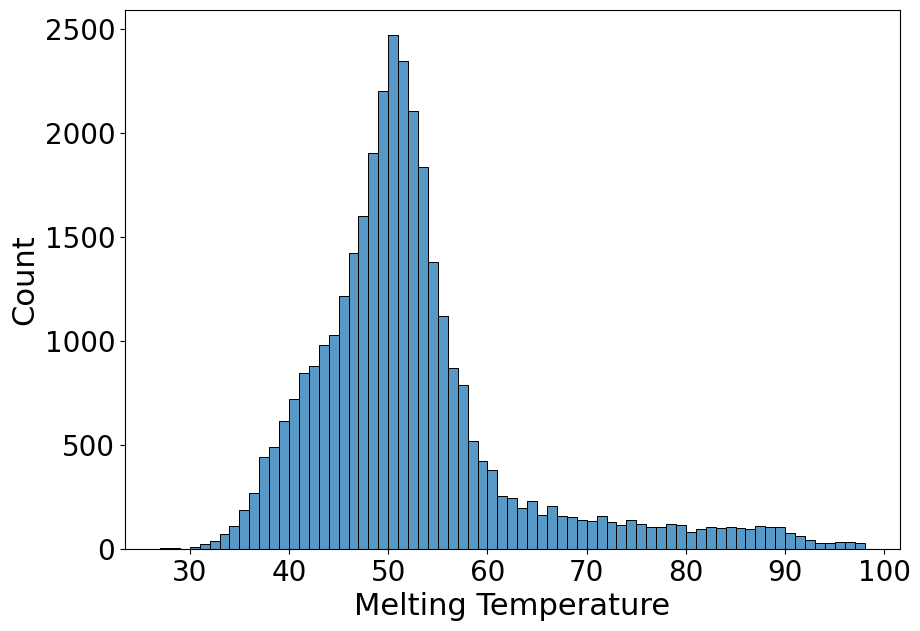

In [8]:
plt.figure(figsize=[10,7])
df_data = pd.DataFrame(df_data)
sns.histplot(data=df_data, x= "Melting Temperature", palette="light:g", bins = 71)
plt.show()

# Dealing with the evolutionary correlated data

Since the sequences are all originating from a common ansestor the data will contain hightly correlated properties. We thus need to correct for this correlation when training and evaluating our machine learning models, or we run the risk of introducing data leakage. A widely used techneque for sequence data is to cluster the sequences and split the data on clustering level. (Protin net reference) For structure prediction a widely used threashold for clustering has been 30% identity. To investigate if this is a sutible threshold for Melting temperature predictions we can analyse how well  sequence identity correlates with melting tempetarutre.  

## Blast

To calculate identity between sequences we can use BLAST. It is not the best algorithem since it is not as sensitive at lower identities so some sequences might not find any similar sequences at all.

In [ ]:
! makeblastdb -in ../data/all_tms_noredun.fasta -out ../data/blast_DB/all_tms_db -dbtype prot

In [ ]:
! blastp -query ../data/all_tms_noredun.fasta -out ../results/blast/blast_record -outfmt "6 qseqid sseqid pident" -db ../data/data_Tm/blast_DB/all_tms_db -num_threads 10

In [2]:
## Read the records file

df = pd.read_csv("../results/blast/blast_record", sep="\t", names=["Query", "Target", "identity"]).drop_duplicates()

In [6]:
df["tm_query"] = df['Query'].apply(lambda x: tem(x, df_tm))
df["tm_target"] = df['Target'].apply(lambda x: tem(x, df_tm))

df["Temperature range"] = abs(df["tm_query"]-df["tm_target"])
df["Identity range"] = df["identity"].apply(bins)
df.dropna().head()

,Query,Target,identity,tm_query,tm_target,Temperature range,Identity range
0,A0A023PXQ4,A0A023PXQ4,100.000,52.403034,52.403034,0.000000,100 = X
1,A0A023PXQ4,Q13424,29.545,52.403034,50.782500,1.620534,0 > x<= 40
2,A0A023PXQ4,P51592,40.476,52.403034,45.517146,6.885888,40 > X >= 60
3,A0A023PXQ4,Q8RWF0,41.860,52.403034,48.566546,3.836488,40 > X >= 60
4,A0A023PXQ4,R4YL54,25.000,52.403034,54.032579,1.629545,0 > x<= 40


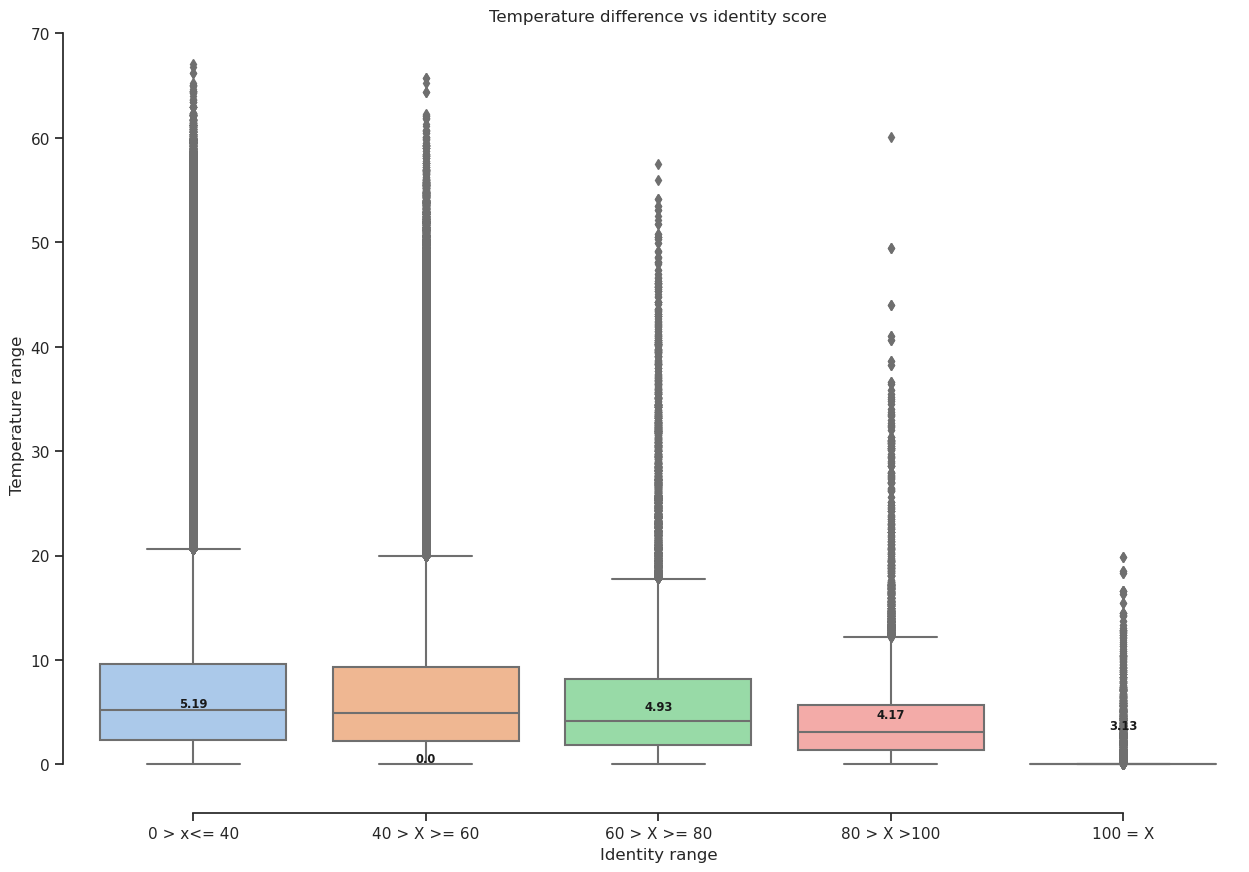

In [8]:
fig = plt.figure(figsize=[15,10])
sns.set_theme(style="ticks", palette="pastel")
# Draw a nested boxplot to show bills by day and time
box_plot = sns.boxplot(x="Identity range",
            y="Temperature range",
            data=df,
            order=["0 > x<= 40", "40 > X >= 60", "60 > X >= 80", "80 > X >100",  "100 = X"])

medians = df.groupby(["Identity range"])["Temperature range"].median().round(2)# .sort_values(ascending=False)
vertical_offset = df["Temperature range"].median() * 0.05 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='k',weight='semibold')
sns.despine(offset=10, trim=True)
plt.title("Temperature difference vs identity score")
plt.show()

/home/sandra/miniconda3/envs/ThermalGAN/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


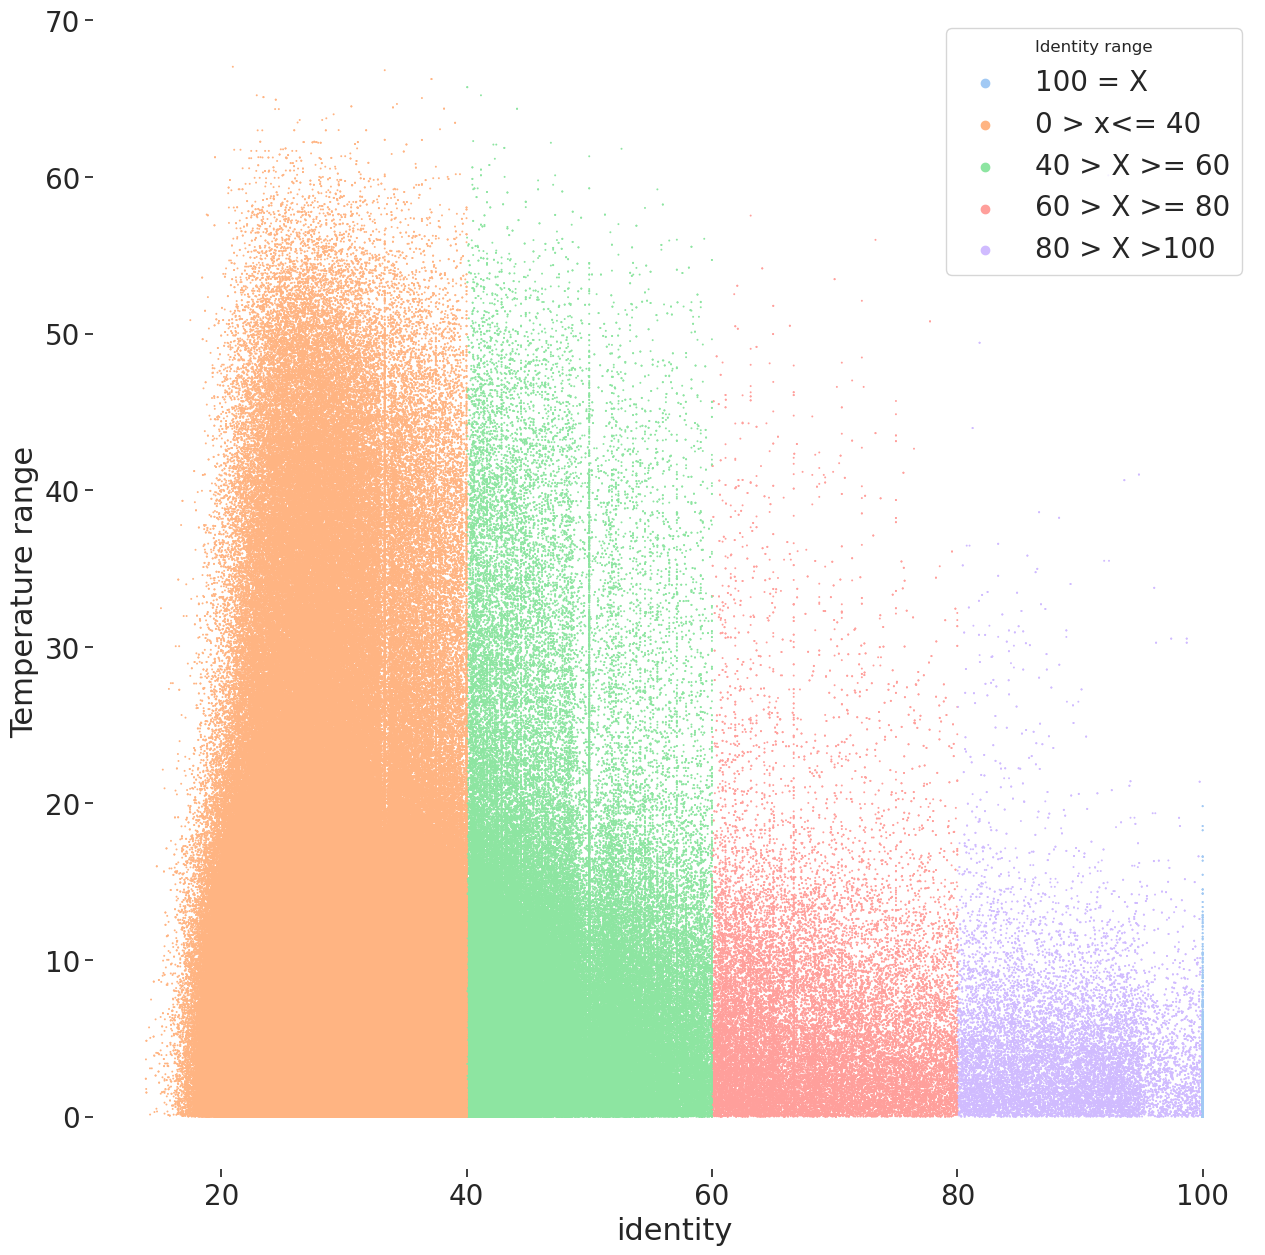

In [31]:
f, ax = plt.subplots(figsize=(15, 15))
sns.despine(f, left=True, bottom=True)

sns.scatterplot(x="identity",
                y="Temperature range",
                hue="Identity range",
                linewidth=0,
                s = 2,
                data=df,
                ax=ax)
plt.show()

<Axes: xlabel='Identity range', ylabel='Correlation'>

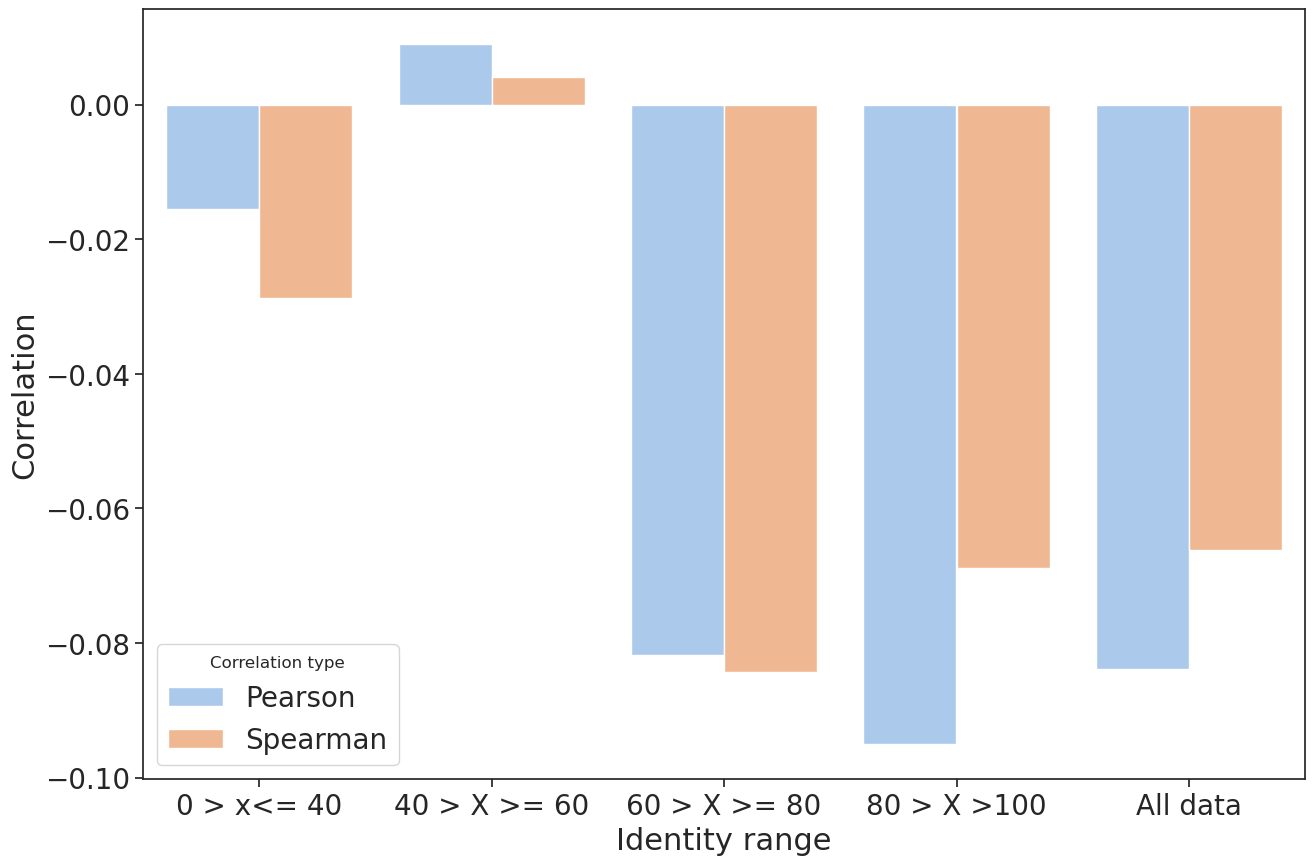

In [32]:
# Correlation 

def corr(df):
    corr_p, corr_p_p = pearsonr(df["identity"], df["Temperature range"])
    corr_s, corr_s_p = spearmanr(df["identity"], df["Temperature range"])
    return corr_p, corr_p_p, corr_s, corr_s_p
    
order=["0 > x<= 40", "40 > X >= 60", "60 > X >= 80", "80 > X >100", "All data"]   
dfs = [df[df["Identity range"] == rec] for rec in order[:-1]]
dfs.append(df)

df_corr = {"Identity range":[], "Pearson":[], "Spearman":[], "P-value Pearson":[], "P-value Spearman":[] }
list_pearson = []
p_p = []
list_spearman = []
s_p = []

for rec, h in zip(dfs, order):
    corr_p, corr_p_p, corr_s, corr_s_p = corr(rec)
    list_pearson.append(corr_p)
    p_p.append(corr_p_p)
    list_spearman.append(corr_s) 
    s_p.append(corr_s_p)
    #df_corr["Identity range"].append(h)
    #df_corr["Pearson"].append(corr_p)
    #df_corr["Spearman"].append(corr_s)
    #df_corr["P-value Pearson"].append(corr_p_p)
    #df_corr["P-value Spearman"].append(corr_s_p)
    pass
df_corr = {"Correlation type":["Pearson", "Spearman"],
           "Identity range":[order, order],
          "Correlation": [list_pearson, list_spearman],
           "P-value":[p_p, s_p]
          }
df_corr = pd.DataFrame(df_corr)

df_corr = df_corr.explode(["Identity range", "Correlation", "P-value"])



f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x = "Identity range", y= "Correlation", hue="Correlation type", order=order, data=df_corr)




In [33]:
print(p_p)
print(s_p)

[1.2778537467217109e-167, 1.265144662421293e-07, 5.767713257900008e-56, 1.138488110138106e-39, 0.0]
[0.0, 0.014359849645045835, 2.2802086142692824e-59, 1.5639274372616806e-21, 0.0]


In [ ]:
## We will use the accepted threashold of 30%

In [1]:
## cluster data
! mmseqs easy-cluster ../data/all_tms_noredun_780.fasta ../data/clu_30 tmp --min-seq-id 0.6 -c 0.8 --cov-mode 1

easy-cluster ../data/all_tms_noredun_780.fasta ../data/clu_30 tmp --min-seq-id 0.6 -c 0.8 --cov-mode 1 

MMseqs Version:                     	13.45111
Substitution matrix                 	nucl:nucleotide.out,aa:blosum62.out
Seed substitution matrix            	nucl:nucleotide.out,aa:VTML80.out
Sensitivity                         	4
k-mer length                        	0
k-score                             	2147483647
Alphabet size                       	nucl:5,aa:21
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit                  	0
Coverage threshold                  	0.8
Coverage mode                       	1
Compositional bias                  	1
Diagonal scoring                    	true
Exact k-mer matching                	0
Mask residues                       	1
Mask lower case residues            	0
Minimum diagonal score              	15
Include ide

In [7]:
#create test set out of top 10 clusters

##Make test set

! cat ../data/clu_30_cluster.tsv | cut -f 1 | uniq -c | sort -n -r | tail -n 3000 | awk ' { t = $1; $1 = $2; $2 = t; print; } ' | cut -f 1 -d " " > ../data/test_clusters.tsv
##Make validation set

! cat ../data/clu_30_cluster.tsv| cut -f 1 | uniq -c | sort -n -r | tail -n 6000 | head -n 3000| awk ' { t = $1; $1 = $2; $2 = t; print; } ' | cut -f 1 -d " " > ../data/val_clusters.tsv

##Make training set

! cat ../data/clu_30_cluster.tsv| cut -f 1 | uniq -c | sort -n -r |  head -n -6000| awk ' { t = $1; $1 = $2; $2 = t; print; } ' | cut -f 1 -d " " > ../data/train_clusters.tsv

Q94AQ8 1
Q94AI6 1
Q94A94 1
Q94A82 1
Q94A68 1
Q94A38 1
Q949Y3 1
Q949X9 1
Q94915 1
Q94913 1
Q94901 1
Q94547 1
Q944L7 1
Q944A9 1
Q944A6 1
Q94416 1
Q94401 1
Q94361 1
Q94312 1
Q94261 1
Q94218 1
Q941D3 1
Q94131 1
Q94129 1
Q940U6 1
Q940H8 1
Q94050 1
Q93ZV7 1
Q93ZT6 1
Q93ZN9 1
Q93ZC9 1
Q93ZB2 1
Q93Z16 1
Q93Y07 1
Q93WI0 1
Q93VR4 1
Q93VR3 1
Q93VC7 1
Q93K97 1
Q93HR1 1
Q93895 1
Q93832 1
Q93796 1
Q93726 1
Q93649 1
Q93568 1
Q93535 1
Q93425 1
Q93380 1
Q93015-2 1
Q92838-2 1
Q92834-4 1
Q92698 1
Q92681 1
Q92667-2 1
Q92624 1
Q92567-2 1
Q92537 1
Q92522 1
Q92482-2 1
Q92331 1
Q922U1 1
Q921L7 1
Q921L3 1
Q920V1 1
Q91X88 1
Q91WX5 1
Q91WG3 1
Q91W00 1
Q91VJ1 1
Q91VC9 1
Q91VC4 1
Q91V80 1
Q90490 1
Q8XAW1 1
Q8WXW3 1
Q8WXD5 1
Q8WXD2 1
Q8WXA2-2 1
Q8WWZ3-2 1
Q8WWM9 1
Q8WWK9-5 1
Q8WW35 1
Q8WVV4 1
Q8WVT3 1
Q8WVK2 1
Q8WV07 1
Q8WUY8 1
Q8WUU5 1
Q8WUR7 1
Q8WUE5 1
Q8WUA4-2 1
Q8WU20 1
Q8WU17 1
Q8WTX9 1
Q8WTW4 1
Q8WTC1 1
Q8WSW2 1
Q8WSN2 1
Q8WR43 1
Q8WQF4 1
Q8WQE0 1
Q8WQB4 1
Q8WQB0 1
Q8WQA4 1
Q8W4I6 1
Q8W4F1 1
Q8W4E6 1
Q8W487 1

In [6]:
! cat ../data/val_clusters.tsv| cut -f 1 | uniq -c | sort -n -r | wc



   1000    2000   15002
